In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


from keras.datasets import mnist, fashion_mnist
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt


2023-10-09 19:37:00.580483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Autoencoders

Autoencoders are our first experience with *Unsupervised* Neural Networks. The goal of an Autoencoder is to learn how to compress the data with the **encoder** portion of the network, and then uncompress it with the **decoder** portion. 

In order to enforce this compression we typically either:

- have a hidden layer with **low dimensionality** (very few nodes)
OR
- enforce **sparcity** (many nodes are 0) in the hidden layer

## Denoising as Regularization
In addition to the two types of penalties we talked about (penalties on the hidden layer and penalties on the derivative) which both help regularize our Autoencoders, we also talked about **Denoising Autoencoders**. DAE's add a little bit of noise (i.e. adding small random values to our input) to our data but *still ask the model to return the original input*. Adding a little bit of noise to the input forces the AE to learn that small changes (noise) to the input should not drastically change what the output should be.


## Autoencoders as Non-Linear Principal Component Analysis
We often say that autoencoders do non-linear PCA, because like PCA, autoencoders learn to represent *most* of the information in the data using a smaller set of variables. However unlike PCA, the "components" or compressed representation of the data doesn't have to be a *linear combination* of the input variables. We can add non-linear activation funcitons, or have a *deep* encoder which allows more complex combinations of the input variables. 

<img src="https://drive.google.com/uc?export=view&id=1q670OFb8hLd6FhGcBmJcqwfcmw5uz9Ag" alt="Q" width = "200px"/>

## Convolutional Autoencoders
And the encoder and decoder don't have to be just Dense, Feed Forward layers. We can also use Convolutional and Pooling layers in order to make Convolutional Autoencoders which can compress images.

<img src="https://drive.google.com/uc?export=view&id=1aJ2MXRfHqMt07Z4ukICUkRqc2t9Dr8y9" alt="Q" width = "400px" />


## Building a FF Autoencoder in Keras
We can theoretically build an autoencoder using a simple stack of layers (e.g. through `Sequential`), however, we're often interested in using the encoder and decoder *separately* once the model is trained, so we'll often use the Functional API to build our Autoencoders so that we can separate them. 

In [2]:
inshape = 30
encoding_dim = 5

input_data = kb.Input(shape = (inshape,), name = "ae_input")
encoded = kb.layers.Dense(encoding_dim, name = "encoding")(input_data)
decoded = kb.layers.Dense(inshape, name = "decoding")(encoded)

# AE
autoencoder = kb.Model(inputs = input_data,
                       outputs = decoded)

# encoder
encoder = kb.Model(inputs = input_data,
                   outputs = encoded)


# decoder
encoded_input = kb.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = kb.Model(inputs = encoded_input,
                   outputs = decoder_layer(encoded_input))

2023-03-12 17:30:54.647921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 30)]              0         
                                                                 
 encoding (Dense)            (None, 5)                 155       
                                                                 
 decoding (Dense)            (None, 30)                180       
                                                                 
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [4]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 30)]              0         
                                                                 
 encoding (Dense)            (None, 5)                 155       
                                                                 
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________


In [5]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 decoding (Dense)            (None, 30)                180       
                                                                 
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


### Loading in Data

Loading in Data to use in Tensorflow can be a little tricky when it's not data that comes pre-loaded with tf. 

First we're going to load in a Breast Cancer dataset using pandas, and select the columns that we want to put into our autoencoder (all the different features of the breast cancer biopsy).

Then we convert it to a tensor...because that's what **tensor**flow expects as input.

In [6]:
# load in data
bc = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/BreastCancer.csv")

# grab necessary columns
feat = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
bc_compress = bc[feat]

# convert to tensorflow data
bc_compress_tf = tf.convert_to_tensor(bc_compress)

Next, we'll do a train/test split.

First we calculate how many data points go in train, and how many go in test. 

Then we use tensorflow's `split()` function to do the train test split. We need to shuffle our data using `tf.random.shuffle()` first, otherwise it will split our data so that the first rows are in the train and the last rows are in test (this is like setting the `shuffle = True` argument in a `train_test_split()` or `KFold()` in `sklearn`) 

In [7]:
# TTS

# calculate the number of data points in each set
test_prop = bc_compress_tf.shape[0]//5
train_prop = bc_compress_tf.shape[0] - test_prop

# split
x_train, x_test = tf.split(tf.random.shuffle(bc_compress_tf), #shuffle before splitting
                           [train_prop, test_prop], # number of data points in each set
                           0) # split the rows, not columns

print(x_train.shape, x_test.shape)

(456, 30) (113, 30)


In [8]:
# compile and train

autoencoder.compile(loss = "mean_squared_error", optimizer = "adam")
autoencoder.fit(x_train, x_train, 
                epochs = 500,
                validation_data = (x_test, x_test))

Epoch 1/500
15/15 [==============================] - 1s 24ms/step - loss: 69184.4453 - val_loss: 65629.9453
Epoch 2/500
15/15 [==============================] - 0s 4ms/step - loss: 57674.1445 - val_loss: 55410.5898
Epoch 3/500
15/15 [==============================] - 0s 3ms/step - loss: 48905.1016 - val_loss: 46991.7070
Epoch 4/500
15/15 [==============================] - 0s 3ms/step - loss: 41572.5273 - val_loss: 40188.7930
Epoch 5/500
15/15 [==============================] - 0s 4ms/step - loss: 35582.4766 - val_loss: 34381.1289
Epoch 6/500
15/15 [==============================] - 0s 4ms/step - loss: 30189.6328 - val_loss: 28873.1895
Epoch 7/500
15/15 [==============================] - 0s 4ms/step - loss: 25037.9980 - val_loss: 23488.0391
Epoch 8/500
15/15 [==============================] - 0s 4ms/step - loss: 20001.2148 - val_loss: 18454.9961
Epoch 9/500
15/15 [==============================] - 0s 4ms/step - loss: 15284.3945 - val_loss: 13829.4482
Epoch 10/500
15/15 [================

Yay! We trained an autoencoder to compress our breast cancer data. 

We now have a few options of what to do with it. One option is to use the `encoder` to compress all our our data and then feed that data through a predictive model. 

In [9]:
# one way to do this using sklearn's tts
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(bc[feat],
                                                    bc["diagnosis"],
                                                    test_size = 0.2)

x_train_compressed = encoder(tf.convert_to_tensor(x_train))
x_test_compressed = encoder(tf.convert_to_tensor(x_test))

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

print(x_train_compressed.shape, x_test_compressed.shape)

print(y_train.shape, y_test.shape)

(455, 5) (114, 5)
(455, 1) (114, 1)


In [10]:
model = kb.Sequential([
    kb.layers.Dense(5, input_shape = (5,), activation = "relu"),
    kb.layers.Dense(3, activation = "relu"),
    kb.layers.Dense(2, activation = "relu"),
    kb.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
model.fit(x_train_compressed, y_train,
          epochs = 100,
          validation_data = (x_test_compressed, y_test))

Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 1.2223 - accuracy: 0.5714 - val_loss: 0.6896 - val_accuracy: 0.6754
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.6154 - val_loss: 0.6871 - val_accuracy: 0.6754
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.6154 - val_loss: 0.6846 - val_accuracy: 0.6754
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.6154 - val_loss: 0.6822 - val_accuracy: 0.6754
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.6154 - val_loss: 0.6798 - val_accuracy: 0.6754
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.6154 - val_loss: 0.6773 - val_accuracy: 0.6754
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6154 - val_loss: 0.6752 - val_accuracy: 0.6754
Epoch 8/100


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


Another option we have is to add the encoder as a **non-trainable** layer to our neural network. This way the NN will take in raw data, the encoder will compress it, and then pass it along to the next layer of the network.

In [25]:
# tell our model NOT to change the encoder
encoder.trainable = False

input = kb.Input(shape = (30,))
x = encoder(input)
x = kb.layers.Dense(5, input_shape = (5,), activation = "relu", name = "5Dense")(x)
x = kb.layers.Dense(3, activation = "relu", name = "3Dense")(x)
x = kb.layers.Dense(2, activation = "relu", name = "2Dense")(x)
output = kb.layers.Dense(1, activation = "sigmoid")(x)


model_encoded = kb.Model(inputs = input,
                         outputs = output)

In [26]:
model_encoded.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 model_1 (Functional)        (None, 5)                 155       
                                                                 
 5Dense (Dense)              (None, 5)                 30        
                                                                 
 3Dense (Dense)              (None, 3)                 18        
                                                                 
 2Dense (Dense)              (None, 2)                 8         
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 214
Trainable params: 59
Non-trainable params

In [27]:
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

model_encoded.compile(loss = "binary_crossentropy",
                      optimizer = "sgd",
                      metrics = ["accuracy"])
model_encoded.fit(x_train, y_train,
          epochs = 200,
          validation_data = (x_test, y_test))

Epoch 1/200
15/15 [==============================] - 1s 15ms/step - loss: 0.6923 - accuracy: 0.6154 - val_loss: 0.6901 - val_accuracy: 0.6754
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.6154 - val_loss: 0.6870 - val_accuracy: 0.6754
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.6154 - val_loss: 0.6841 - val_accuracy: 0.6754
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6154 - val_loss: 0.6816 - val_accuracy: 0.6754
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6154 - val_loss: 0.6797 - val_accuracy: 0.6754
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.6154 - val_loss: 0.6775 - val_accuracy: 0.6754
Epoch 7/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6154 - val_loss: 0.6758 - val_accuracy: 0.6754
Epoch 8/200


Voila! We basically built the same neural nework, except this one does the pre-processing for us using the pre-trained encoder layer from our autoencoder.

## Denoising Convolutional AE

Now let's build a de-noising autoencoder. First, we load in our data and add a little bit of noise.

In [2]:
# load data from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# rescale and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# make sure noise doesnt give us an invalid value outside [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

let's plot some of the noisy and non-noisy data!

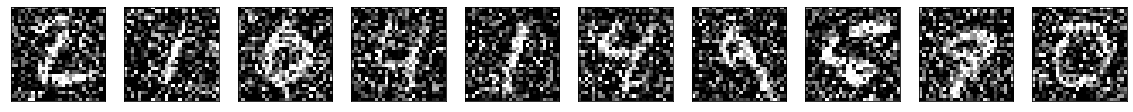

In [31]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

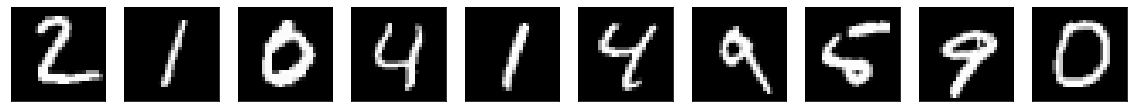

In [32]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Building the DAE
Now we need to build our model. Remember, the goal of the encoding portion of the model is to compress our image (meaning we want it's output to be SMALLER than the image).

Then we need to create some layers that learn to de-compress the image. We can use any combination of `UpSampling2D()` layers (the opposite of `MaxPooling2D()`), `Conv2D()` layers, or `Conv2DTranspose()` layers (the opposite of `Conv2D()`). What we want to keep in mind is that our **input** needs to be the same dimensions as our **output**. 

For this example (from Keras), you're going to use `UpSampling2D()` to upscale your compressed image, and a `Conv2D()` layer at the end to get our image back to 1 channel (rather than 32).

In [38]:
# set input to be a 28x28 image
input_img = kb.Input(shape=(28, 28, 1))

# encoding
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = kb.layers.MaxPooling2D((2, 2), padding='same')(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = kb.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

# decoding
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = kb.layers.UpSampling2D((2, 2))(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = kb.layers.UpSampling2D((2, 2))(x)
decoded = kb.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = kb.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=1,
                validation_data=(x_test_noisy, x_test))

1875/1875 [==============================] - 118s 62ms/step - loss: 0.1213 - val_loss: 0.1027


In [39]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 32)          9248

In [45]:
# We're not going to use this today, but we COULD if we wanted...
# create encoder model
encoder_conv = kb.Model(inputs = autoencoder.input,
                        outputs = encoded)

# get compressed image
x_example = encoder_conv(x_train_noisy[0])

#### Plot DAE
Now that we've trained the denoising autoencoder, let's see how it does on a few samples.

In [46]:
# denoise using DAE
x_train_pred = autoencoder.predict(x_train_noisy)

1875/1875 [==============================] - 16s 8ms/step


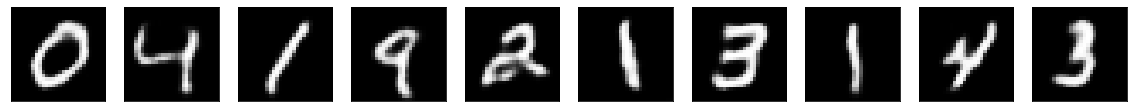

In [47]:
# plot denoised images
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

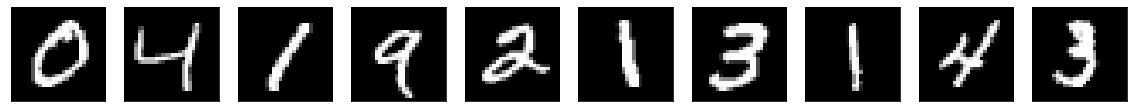

In [48]:
# plot true images
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(Because we did this the simple way and added noise to our dataset, the noise for a given sample will never change. We also could add a `GaussianNoise()` layer to our model in order to change the noise each time, sorta like the data augmentation layers that we used before.)

In [13]:
# W = 28 # input height/width
# K = 3 # kernel size
# P = 0 # padding
# S = 1 # stride

# # output dimensions
# ((W - K + P + S)/S)

# set input to be a 28x28 image
input_img = kb.Input(shape=(28, 28, 1))

# encoding
#28,28,1 --> 28,28,32 --> 14,14,32 --> 14,14,32 --> 7,7,32
x = kb.layers.GaussianNoise(0.5)(input_img)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = kb.layers.MaxPooling2D((2, 2), padding='same')(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = kb.layers.MaxPooling2D((2, 2), padding='same')(x)

# # encoding alternate
# #28,28,1 --> 14,14,32 --> 7,7,32
# x = kb.layers.GaussianNoise(0.5)(input_img)
# x = kb.layers.Conv2D(32, (2, 2), strides = (2,2), activation='relu', padding='valid')(x)
# encoded = kb.layers.Conv2D(32, (2, 2), strides = (2,2), activation='relu', padding='valid')(x)


# At this point the representation is (7, 7, 32)

# # decoding
# # 7,7,32 --> 7,7,32 --> 14,14,32 --> 14,14,32 --> 28,28,32 --> 28,28,1
# x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = kb.layers.UpSampling2D((2, 2))(x)
# x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = kb.layers.UpSampling2D((2, 2))(x)
# decoded = kb.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# decoding alternate
# 7,7,32 -->  14,14,32 --> 28,28,32 --> 28,28,1
x = kb.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = kb.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = kb.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder

autoencoder = kb.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=1,
                validation_data=(x_test_noisy, x_test))

autoencoder.summary()

1875/1875 [==============================] - 96s 51ms/step - loss: 0.1244 - val_loss: 0.1118
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 gaussian_noise_10 (Gaussia  (None, 28, 28, 1)         0         
 nNoise)                                                         
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 32)        160       
                                                                 
 conv2d_39 (Conv2D)          (None, 7, 7, 32)          4128      
                                                                 
 conv2d_transpose_12 (Conv2  (None, 14, 14, 32)        9248      
 DTranspose)                                                     
                               